## Import Lib

In [1]:
# basics lib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

**Read Dataset**

In [2]:
# Importing the dataset
DATA_PATH = '../input/sentiment140/training.1600000.processed.noemoticon.csv'
DATASET_COLUMNS  = ["Label", "Id", "Date", "Flag", "User_Id", "Tweet"]
DATASET_ENCODING = "ISO-8859-1"
df_tweets = pd.read_csv(DATA_PATH,encoding=DATASET_ENCODING , names=DATASET_COLUMNS)
df_tweets.head()

,Label,Id,Date,Flag,User_Id,Tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## EDA

In [3]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   Label    1600000 non-null  int64 
 1   Id       1600000 non-null  int64 
 2   Date     1600000 non-null  object
 3   Flag     1600000 non-null  object
 4   User_Id  1600000 non-null  object
 5   Tweet    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [4]:
df_tweets = df_tweets[["Tweet", "Label"]]
df_tweets.head()

,Tweet,Label
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [5]:
df_tweets.isnull().sum()

Tweet    0
Label    0
dtype: int64

In [6]:
df_tweets['Length'] = df_tweets.Tweet.apply(len)
df_tweets.head()

,Tweet,Label,Length
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,115
1,is upset that he can't update his Facebook by ...,0,111
2,@Kenichan I dived many times for the ball. Man...,0,89
3,my whole body feels itchy and like its on fire,0,47
4,"@nationwideclass no, it's not behaving at all....",0,111


In [7]:
print("Max Tweet Length = ", df_tweets.Length.max())
print("="*25)
print("Min Tweet Length = ", df_tweets.Length.min())

Max Tweet Length =  374
Min Tweet Length =  6


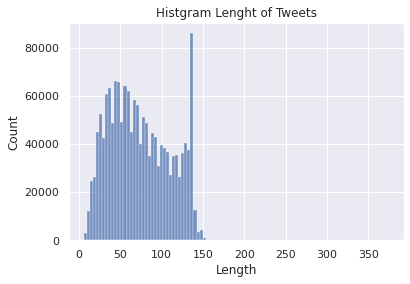

In [8]:
sns.set()
sns.histplot(x="Length", data=df_tweets, bins=100)
plt.title("Histgram Lenght of Tweets")
plt.show()

In [9]:
print("Average Length of Tweets = ", round(df_tweets.Length.mean()))

Average Length of Tweets =  74


In [10]:
positive = df_tweets[df_tweets.Label==0]
positive.head()

,Tweet,Label,Length
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,115
1,is upset that he can't update his Facebook by ...,0,111
2,@Kenichan I dived many times for the ball. Man...,0,89
3,my whole body feels itchy and like its on fire,0,47
4,"@nationwideclass no, it's not behaving at all....",0,111


In [11]:
negative = df_tweets[df_tweets.Label!=0]
negative.head()

,Tweet,Label,Length
800000,I LOVE @Health4UandPets u guys r the best!!,4,44
800001,im meeting up with one of my besties tonight! ...,4,72
800002,"@DaRealSunisaKim Thanks for the Twitter add, S...",4,137
800003,Being sick can be really cheap when it hurts t...,4,104
800004,@LovesBrooklyn2 he has that effect on everyone,4,47


In [12]:
sentences = positive.Tweet.to_list()

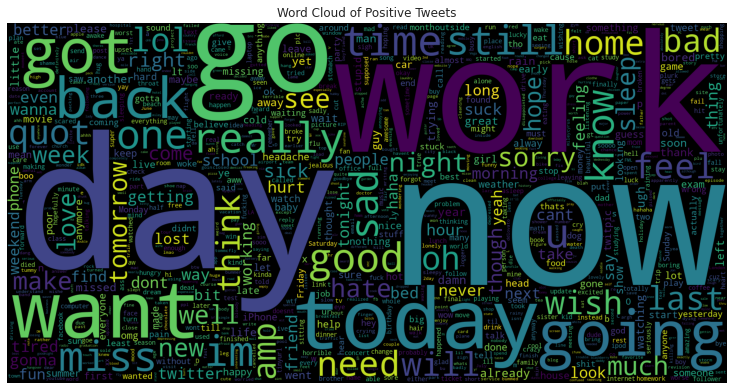

In [13]:
from wordcloud import WordCloud
plt.figure(figsize=(10,10))

wordcloud_true = WordCloud(max_words = 1000 ,
                           width = 1600 ,
                           height = 800,
                           collocations=False).generate(" ".join(sentences))

plt.imshow(wordcloud_true)
plt.axis('off')
plt.title("Word Cloud of Positive Tweets")
plt.tight_layout(pad=0)
plt.show()

In [14]:
sentences = negative.Tweet.to_list()

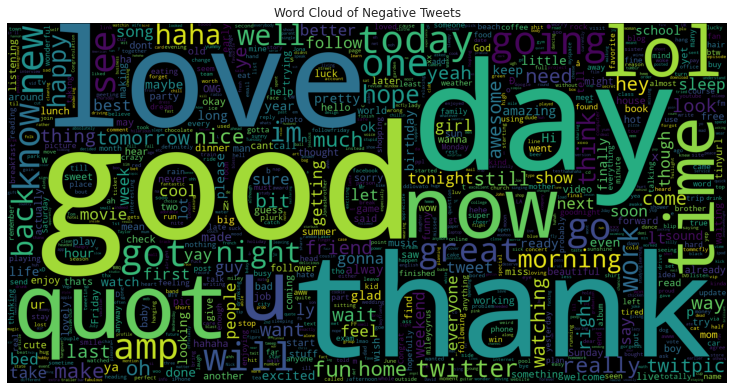

In [15]:
plt.figure(figsize=(10,10))

wordcloud_true = WordCloud(max_words = 1000 ,
                           width = 1600 ,
                           height = 800,
                           collocations=False).generate(" ".join(sentences))

plt.imshow(wordcloud_true)
plt.axis('off')
plt.title("Word Cloud of Negative Tweets")
plt.tight_layout(pad=0)
plt.show()

## Data Preparation

In [16]:
# text cleaning lib
import string
import nltk
import re
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer

In [17]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [18]:
words = set(nltk.corpus.words.words())
Punctuation = string.punctuation
print("Punctuation = ", Punctuation)
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

Punctuation =  !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [19]:
# take text and preprocess '
# remove stopwords [a, the, and, thus, ... etc] 
# and punctations[,%$ ..etc] and len of text less than 3' 
def clean_text(text):
    """
        text: a string 
        return: cleaned string
    """ 
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    for emoji in emojis.keys():
        text = text.replace(emoji, "EMOJI" + emojis[emoji])
    text = re.sub(r'([a-z])\1{2,}', r'\1', text)
    result = []
    for token in simple_preprocess(text):
        if token not in STOPWORDS and token not in Punctuation and  len(token) >= 3 :
            token = token.lower() 
            result.append(token)    
    return " ".join(result)

In [20]:
df_tweets['Tweet'] = df_tweets['Tweet'].map(clean_text)
df_tweets.head()

,Tweet,Label,Length
0,bummer shoulda got david carr day,0,115
1,upset update facebook texting result school to...,0,111
2,dived times ball managed save rest bounds,0,89
3,body feels itchy like,0,47
4,behaving mad,0,111


In [21]:
df_tweets.Tweet.isnull().sum()

0

In [22]:
df_tweets.Length = df_tweets.Tweet.apply(lambda x:len(x.split(" ")))
df_tweets.head()

,Tweet,Label,Length
0,bummer shoulda got david carr day,0,6
1,upset update facebook texting result school to...,0,8
2,dived times ball managed save rest bounds,0,7
3,body feels itchy like,0,4
4,behaving mad,0,2


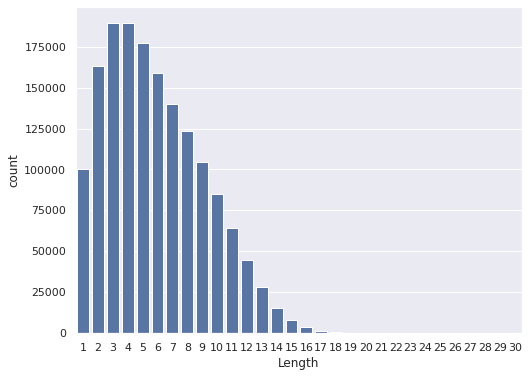

In [23]:
plt.figure(figsize=(8,6))
sns.countplot(x="Length", data=df_tweets, color="b")
plt.show()

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_tweets.Tweet)
X.shape

(1600000, 286193)

In [25]:
print([*vectorizer.vocabulary_.keys()][:100])

['bummer', 'shoulda', 'got', 'david', 'carr', 'day', 'upset', 'update', 'facebook', 'texting', 'result', 'school', 'today', 'blah', 'dived', 'times', 'ball', 'managed', 'save', 'rest', 'bounds', 'body', 'feels', 'itchy', 'like', 'behaving', 'mad', 'crew', 'need', 'hug', 'hey', 'long', 'time', 'yes', 'rains', 'bit', 'lol', 'fine', 'thanks', 'nope', 'que', 'muera', 'spring', 'break', 'plain', 'city', 'snowing', 'pierced', 'ears', 'couldn', 'bear', 'watch', 'thought', 'loss', 'embarrassing', 'counts', 'idk', 'talk', 'anymore', 'gun', 'zac', 'snyder', 'doucheclown', 'wish', 'miss', 'iamlilnicki', 'premiere', 'hollis', 'death', 'scene', 'hurt', 'severely', 'film', 'wry', 'directors', 'cut', 'file', 'taxes', 'ahh', 'ive', 'wanted', 'rent', 'love', 'soundtrack', 'dear', 'drinking', 'forgotten', 'table', 'drinks', 'friend', 'called', 'asked', 'meet', 'mid', 'valley', 'sigh', 'baked', 'cake', 'ated', 'week']


In [26]:
# label encode for target columns(Industry).
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
y = encoder.fit_transform(np.array(df_tweets.Label).reshape(-1, 1)).astype('int')

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42)

## Modeling

In [28]:
from sklearn.metrics import classification_report, accuracy_score

**Naive Bayes**

In [29]:
from sklearn.naive_bayes import MultinomialNB
naive = MultinomialNB()
naive.fit(X_train, y_train)
accuracy_score(naive.predict(X_train), y_train)

0.7931553571428571

In [30]:
accuracy_score(y_test, naive.predict(X_test))

0.75683125

**SVM**

In [31]:
from sklearn.svm import LinearSVC
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
accuracy_score(SVCmodel.predict(X_train), y_train)

0.8213875

In [32]:
accuracy_score(SVCmodel.predict(X_test), y_test)

0.7647833333333334

**Logistic Regression**

In [33]:
from sklearn.linear_model import LogisticRegression
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
accuracy_score(LRmodel.predict(X_train), y_train)

0.8045276785714286

In [34]:
y_pred = LRmodel.predict(X_test)
accuracy_score(y_pred, y_test)

0.7715604166666666

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.75      0.77    239361
           1       0.76      0.80      0.78    240639

    accuracy                           0.77    480000
   macro avg       0.77      0.77      0.77    480000
weighted avg       0.77      0.77      0.77    480000



## Save Models

In [36]:
# save models
import pickle

In [37]:
pickle.dump(vectorizer, open('tranform.pkl', 'wb'))
pickle.dump(naive, open('Naive_model.pkl', 'wb'))
pickle.dump(LRmodel, open('LRmodel.pkl', 'wb'))
pickle.dump(SVCmodel, open('SVCmodel.pkl', 'wb'))

### Thanks For Read My NoteBook :)